In [1]:
!pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflo

In [39]:
import urllib.parse
from fastcore.all import *
import json

def query_lexica(search_term):
    term_encoded = urllib.parse.quote_plus(search_term)
    full_query = "https://lexica.art/api/v1/search?q={0}".format(term_encoded)
    images_json = urlread(full_query)
    if not images_json:
        return None
    images = json.loads(images_json)
    return images['images']

query_lexica('white shark')[0]

{'id': '01c85883-c850-4520-addf-961838e01314',
 'gallery': 'https://lexica.art?q=01c85883-c850-4520-addf-961838e01314',
 'src': 'https://lexica-serve-encoded-images.sharif.workers.dev/md/01c85883-c850-4520-addf-961838e01314',
 'srcSmall': 'https://lexica-serve-encoded-images.sharif.workers.dev/sm/01c85883-c850-4520-addf-961838e01314',
 'prompt': 'giant shark smiling, trending on artstation, dark atmospheric lighting rear view sacred geometry, 8 k ',
 'width': 512,
 'height': 512,
 'seed': '3132928249',
 'grid': False,
 'model': 'stable-diffusion',
 'promptid': 'cab093b0-0bda-4c13-89ac-bd91edf78385'}

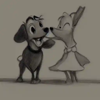

In [15]:
from fastdownload import *
import time
from pathlib import Path

def save_images_from_lexica(search_term, folder=Path("stable-diffusion"), num_images=1):
    images_info = query_lexica(search_term)
    image_paths = []
    for i in range(num_images):
        if i >= len(images_info):
            return
        cur_info = images_info[i]
        file = folder / "{0}.png".format(cur_info["id"])
        download_url(cur_info["srcSmall"], file, show_progress=False)
        image_paths.append(file)
        time.sleep(0.2)
    return image_paths

from fastai.vision.all import *
paths = save_images_from_lexica("best friend")
Image.open(paths[0]).to_thumb(100, 100)

In [19]:
!mkdir -p /root/.kaggle
!cp /kaggle/input/kagglejson/kaggle.json /root/.kaggle
!kaggle datasets download succinctlyai/midjourney-texttoimage
    

 64%|████████████████████████▏             | 33.0M/51.8M [00:00<00:00, 99.6MB/s]
100%|███████████████████████████████████████| 51.8M/51.8M [00:00<00:00, 134MB/s]


## Utilities copied from https://www.kaggle.com/code/succinctlyai/midjourney-text-prompts-huggingface/notebook

In [20]:
# Detect the message type based on the UI components shown to the user.
# See https://discord.com/developers/docs/interactions/message-components#what-is-a-component
COMPONENTS_FOR_INITIAL_AND_VARIATION = set(
    ['U1', 'U2', 'U3', 'U4', '⟳', 'V1', 'V2', 'V3', 'V4'])
COMPONENTS_FOR_UPSCALE = set(
    ['Make Variations', 'Upscale to Max', 'Light Upscale Redo'])

def get_message_type(message):
    """Figures out the message type based on the UI components displayed."""
    for components in message["components"]:
        for component in components["components"]:
            if component["label"] in COMPONENTS_FOR_INITIAL_AND_VARIATION:
                # For (very few) messages that are supposedly initial or variation requests, the content indicates
                # that they are actually upscale requests. We will just put these aside.
                if "Upscaled" in message["content"]:
                    return "INCONCLUSIVE"
                return "INITIAL_OR_VARIATION"
            elif component["label"] in COMPONENTS_FOR_UPSCALE:
                return "UPSCALE"
    return "TEXT_MESSAGE"

In [21]:
import re

def get_prompt(message):
    """Extracts the prompt from the message content, which is located between double stars."""
    content = message["content"]
    # Replace newlines with spaces; makes the regex below work.
    content = content.replace("\n", " ")
    # Find the text enclosed by two consecutive stars.
    BETWEEN_STARS = "\\*\\*(.*?)\\*\\*"
    match = re.search(BETWEEN_STARS, content)
    if match:
        return match.group()[2:-2]  # Exclude the stars.
    

def remove_urls(prompt):
    """Prompts can include both text and images; this method removes the prompt image URLs."""
    URL = "<https[^<]*>?\s"
    matches = re.findall(URL, prompt)
    for match in matches:
        prompt = prompt.replace(match, "")
    return prompt

In [34]:
#!unzip -l /root/.kaggle/midjourney-texttoimage.zip
from zipfile import ZipFile
import json
from collections import namedtuple

image_fields = ['id', 'url', 'prompt']
ImageInfo = namedtuple('ImageInfo', image_fields)

def read_midjourney_image_info(min_word_count=4):
    prompts = set()
    with ZipFile("/root/midjourney-texttoimage.zip") as zf:
        for filename in zf.namelist():
            if filename.endswith('.json'):
                with zf.open(filename) as raw:
                    data = json.load(raw)
                    for messages in data['messages']:
                        message = messages[0]
                        id = message['id']
                        attachments = message.get('attachments')
                        if not attachments:
                            continue
                        url = attachments[0].get('url')
                        if not url:
                            continue
                        message_type = get_message_type(message)
                        if message_type not in ["INITIAL_OR_VARIATION", "UPSCALE"]:
                            continue  # Ignore direct text messages.
                        prompt = get_prompt(message)
                        if not prompt:
                            continue
                        clean_prompt = remove_urls(prompt)
                        if clean_prompt in prompts:
                            continue
                        if len(clean_prompt.split()) < min_word_count:
                            continue
                        prompts.add(clean_prompt)
                        yield ImageInfo(id, url, clean_prompt)                        

from itertools import *

list(islice(read_midjourney_image_info(), 2))
    

[ImageInfo(id='988592560333291620', url='https://cdn.discordapp.com/attachments/988028621421686834/988592559897059378/ac325c7f-b984-454a-bb62-e41dcd3fd5b6_StevenMertens_Bill_Sienkiewicz_technology__Jack_Kirby_machines__retro_futuristic_ghibli_matte_painting.png', prompt='Bill Sienkiewicz technology | Jack Kirby machines |  retro futuristic  ghibli matte painting --aspect 9:19 --no faces'),
 ImageInfo(id='988592106866094130', url='https://cdn.discordapp.com/attachments/988028621421686834/988592101153439774/d0e3d1f3-5a3a-44f2-9a01-1ca230761b93_StevenMertens_bent_twisted_impossible_shape_mysterious_foreboding_Tim_burton_tree.png', prompt='bent twisted impossible shape mysterious foreboding Tim burton tree --aspect 9:19')]

In [35]:
import csv

def save_midjourney_image_info(csv_fname='/kaggle/working/midjourney.csv'):
    with open(csv_fname, 'w') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(image_fields)
        num_rows_written = 0
        for image_info in read_midjourney_image_info():
            writer.writerow(image_info)
            num_rows_written += 1
    return num_rows_written
        
save_midjourney_image_info()

56009

In [50]:
import time

def save_stable_diffusion_image_info(prompts_csv='/kaggle/working/midjourney.csv', csv_to_write='/kaggle/working/stable-diffusion.csv'):
    num_rows_written = 0
    with open(prompts_csv) as prompts_file:
        with open(csv_to_write, 'a') as f:
            writer = csv.writer(f)
            writer.writerow(image_fields)
            for prompt_row in csv.reader(prompts_file):
                prompt_info = ImageInfo(*prompt_row)
                lexica_result = query_lexica(prompt_info.prompt)[0]
                image_info = ImageInfo(lexica_result['id'], lexica_result['src'], lexica_result['prompt'])
                writer.writerow(image_info)
                num_rows_written += 1
                time.sleep(0.2)
    return num_rows_written

save_stable_diffusion_image_info()


HTTP429TooManyRequestsError: HTTP Error 429: Too Many Requests
====Error Body====
<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Access denied | lexica.art used Cloudflare to restrict access</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


<script>
(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1015,helpful:a,version:1}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");
b.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();
</script>

<script defer src="https://performance.radar.cloudflare.com/beacon.js"></script>
</head>
<body>
  <div id="cf-wrapper">
    <div class="cf-alert cf-alert-error cf-cookie-error hidden" id="cookie-alert" data-translate="enable_cookies">Please enable cookies.</div>
    <div id="cf-error-details" class="p-0">
      <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-15 antialiased">
         <h1 class="inline-block md:block mr-2 md:mb-2 font-light text-60 md:text-3xl text-black-dark leading-tight">
           <span data-translate="error">Error</span>
           <span>1015</span>
         </h1>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">Ray ID: 753583c18f655cfb &bull;</span>
         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">2022-10-01 13:23:45 UTC</span>
        <h2 class="text-gray-600 leading-1.3 text-3xl lg:text-2xl font-light">You are being rate limited</h2>
      </header>

      <section class="w-240 lg:w-full mx-auto mb-8 lg:px-8">
          <div id="what-happened-section" class="w-1/2 md:w-full">
            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_happened">What happened?</h2>
            <p>The owner of this website (lexica.art) has banned you temporarily from accessing this website.</p>
            
          </div>

          
      </section>

      <div class="feedback-hidden py-8 text-center" id="error-feedback">
    <div id="error-feedback-survey" class="footer-line-wrapper">
        Was this page helpful?
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>
        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>
    </div>
    <div class="feedback-success feedback-hidden" id="error-feedback-success">
        Thank you for your feedback!
    </div>
</div>


      <div class="cf-error-footer cf-wrapper w-240 lg:w-full py-10 sm:py-4 sm:px-8 mx-auto text-center sm:text-left border-solid border-0 border-t border-gray-300">
  <p class="text-13">
    <span class="cf-footer-item sm:block sm:mb-1">Cloudflare Ray ID: <strong class="font-semibold">753583c18f655cfb</strong></span>
    <span class="cf-footer-separator sm:hidden">&bull;</span>
    <span id="cf-footer-item-ip" class="cf-footer-item hidden sm:block sm:mb-1">
      Your IP:
      <button type="button" id="cf-footer-ip-reveal" class="cf-footer-ip-reveal-btn">Click to reveal</button>
      <span class="hidden" id="cf-footer-ip">35.196.203.192</span>
      <span class="cf-footer-separator sm:hidden">&bull;</span>
    </span>
    <span class="cf-footer-item sm:block sm:mb-1"><span>Performance &amp; security by</span> <a rel="noopener noreferrer" href="https://www.cloudflare.com/5xx-error-landing" id="brand_link" target="_blank">Cloudflare</a></span>
    
  </p>
  <script>(function(){function d(){var b=a.getElementById("cf-footer-item-ip"),c=a.getElementById("cf-footer-ip-reveal");b&&"classList"in b&&(b.classList.remove("hidden"),c.addEventListener("click",function(){c.classList.add("hidden");a.getElementById("cf-footer-ip").classList.remove("hidden")}))}var a=document;document.addEventListener&&a.addEventListener("DOMContentLoaded",d)})();</script>
</div><!-- /.error-footer -->


    </div><!-- /#cf-error-details -->
  </div><!-- /#cf-wrapper -->

  <script>
  window._cf_translation = {};
  
  
</script>

</body>
</html>
